In [ ]:
!git clone https://github.com/Isagi-k/LC25000

Cloning into 'LC25000'...
remote: Enumerating objects: 23731, done.
remote: Total 23731 (delta 0), reused 0 (delta 0), pack-reused 23731
Receiving objects: 100% (23731/23731), 1.66 GiB | 20.43 MiB/s, done.
Updating files: 100% (25001/25001), done.


In [ ]:
import os
from PIL import Image
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.optimizers import Adam, Adamax
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers

import tensorflow_hub as hub
from keras.layers import Input, ReLU
from keras.applications import EfficientNetB5
from keras.callbacks import EarlyStopping

In [ ]:
def otsu_threshold(image):
    # Compute histogram
    histogram, _ = np.histogram(image, bins=256, range=(0, 255))

    # Normalize histogram
    histogram = histogram / float(image.size)

    # Initialization
    maximum_variance = 0
    optimal_threshold = 0

    # Iterate through all possible thresholds
    for threshold in range(256):
        # Compute probabilities
        w0 = np.sum(histogram[:threshold])
        w1 = np.sum(histogram[threshold:])

        # Compute means
        if w0 == 0 or w1 == 0:
            continue

        u0 = np.sum(np.arange(threshold) * histogram[:threshold]) / w0
        u1 = np.sum(np.arange(threshold, 256) * histogram[threshold:]) / w1

        # Compute between-class variance
        variance = w0 * w1 * (u0 - u1) ** 2

        # Update maximum variance and optimal threshold
        if variance > maximum_variance:
            maximum_variance = variance
            optimal_threshold = threshold

    # Apply threshold to the image
    thresholded_image = (image > optimal_threshold) * 255

    return thresholded_image


In [ ]:
data_dir = '/content/LC25000/lung_colon_image_set'
file_paths = []
labels = []

folds = os.listdir(data_dir)
cnt = 0


for fold in folds:
    sub_fold_path = os.path.join(data_dir, fold)


    if os.path.isdir(sub_fold_path):

        sub2folds = os.listdir(sub_fold_path)

        for c_fold in sub2folds:
            c_sub_path = os.path.join(sub_fold_path, c_fold)


            if os.path.isdir(c_sub_path):

                subcfolds = os.listdir(c_sub_path)

                for filepath in subcfolds:

                    file_path = os.path.join(c_sub_path, filepath)


                    if os.path.isfile(file_path):

                        image = cv2.imread(file_path)

                        preprocessed_image = otsu_threshold(image)
                        cnt = cnt+1
                        print(cnt)
                        cv2.imwrite(file_path, preprocessed_image)

                        file_paths.append(file_path)
                        labels.append(c_fold)

fseries = pd.Series(file_paths, name='filepath')
lseries = pd.Series(labels, name='labels')
df = pd.concat([fseries, lseries], axis=1)

print(set(labels))


Streaming output truncated to the last 5000 lines.
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011
20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025
20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037
20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048
20049
20050
20051
20052
20053
20054
20055
20056
20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070
20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082
20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096
20097
20098
20099
20100
20101
20102
20103
20104
20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116
20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127
20128
20129
20130
20131
20132
20133
20134
20135
20136
20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150
20151
20152
20153
20154
20155
20156
20157
20158
20159
2

In [ ]:
train_df, ts_df = train_test_split(df,test_size= 0.2, random_state=42, stratify= df['labels'])
valid_df, test_df = train_test_split(ts_df,test_size= 0.5, random_state=42, stratify= ts_df['labels'])

In [ ]:
print(train_df)

                                                filepath    labels
1495   /content/LC25000/lung_colon_image_set/colon_im...   colon_n
16818  /content/LC25000/lung_colon_image_set/lung_ima...    lung_n
15011  /content/LC25000/lung_colon_image_set/lung_ima...    lung_n
19185  /content/LC25000/lung_colon_image_set/lung_ima...    lung_n
274    /content/LC25000/lung_colon_image_set/colon_im...   colon_n
...                                                  ...       ...
17295  /content/LC25000/lung_colon_image_set/lung_ima...    lung_n
23633  /content/LC25000/lung_colon_image_set/lung_ima...  lung_aca
20841  /content/LC25000/lung_colon_image_set/lung_ima...  lung_aca
15705  /content/LC25000/lung_colon_image_set/lung_ima...    lung_n
22815  /content/LC25000/lung_colon_image_set/lung_ima...  lung_aca

[20000 rows x 2 columns]


In [ ]:
test_df

,filepath,labels
15441,/content/LC25000/lung_colon_image_set/lung_ima...,lung_n
2937,/content/LC25000/lung_colon_image_set/colon_im...,colon_n
13472,/content/LC25000/lung_colon_image_set/lung_ima...,lung_scc
15710,/content/LC25000/lung_colon_image_set/lung_ima...,lung_n
24118,/content/LC25000/lung_colon_image_set/lung_ima...,lung_aca
...,...,...
7397,/content/LC25000/lung_colon_image_set/colon_im...,colon_aca
23022,/content/LC25000/lung_colon_image_set/lung_ima...,lung_aca
17352,/content/LC25000/lung_colon_image_set/lung_ima...,lung_n
10719,/content/LC25000/lung_colon_image_set/lung_ima...,lung_scc


In [ ]:
batch_size= 64
img_size= (224,224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='filepath', y_col='labels',target_size= img_size,
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='filepath', y_col='labels',target_size= img_size,
                                   class_mode= 'categorical', color_mode='rgb', shuffle = True,
                                   batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='filepath', y_col='labels',target_size= img_size,
                                   class_mode= 'categorical', color_mode='rgb', shuffle = False,
                                   batch_size= batch_size)

Found 20000 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.
Found 2500 validated image filenames belonging to 5 classes.


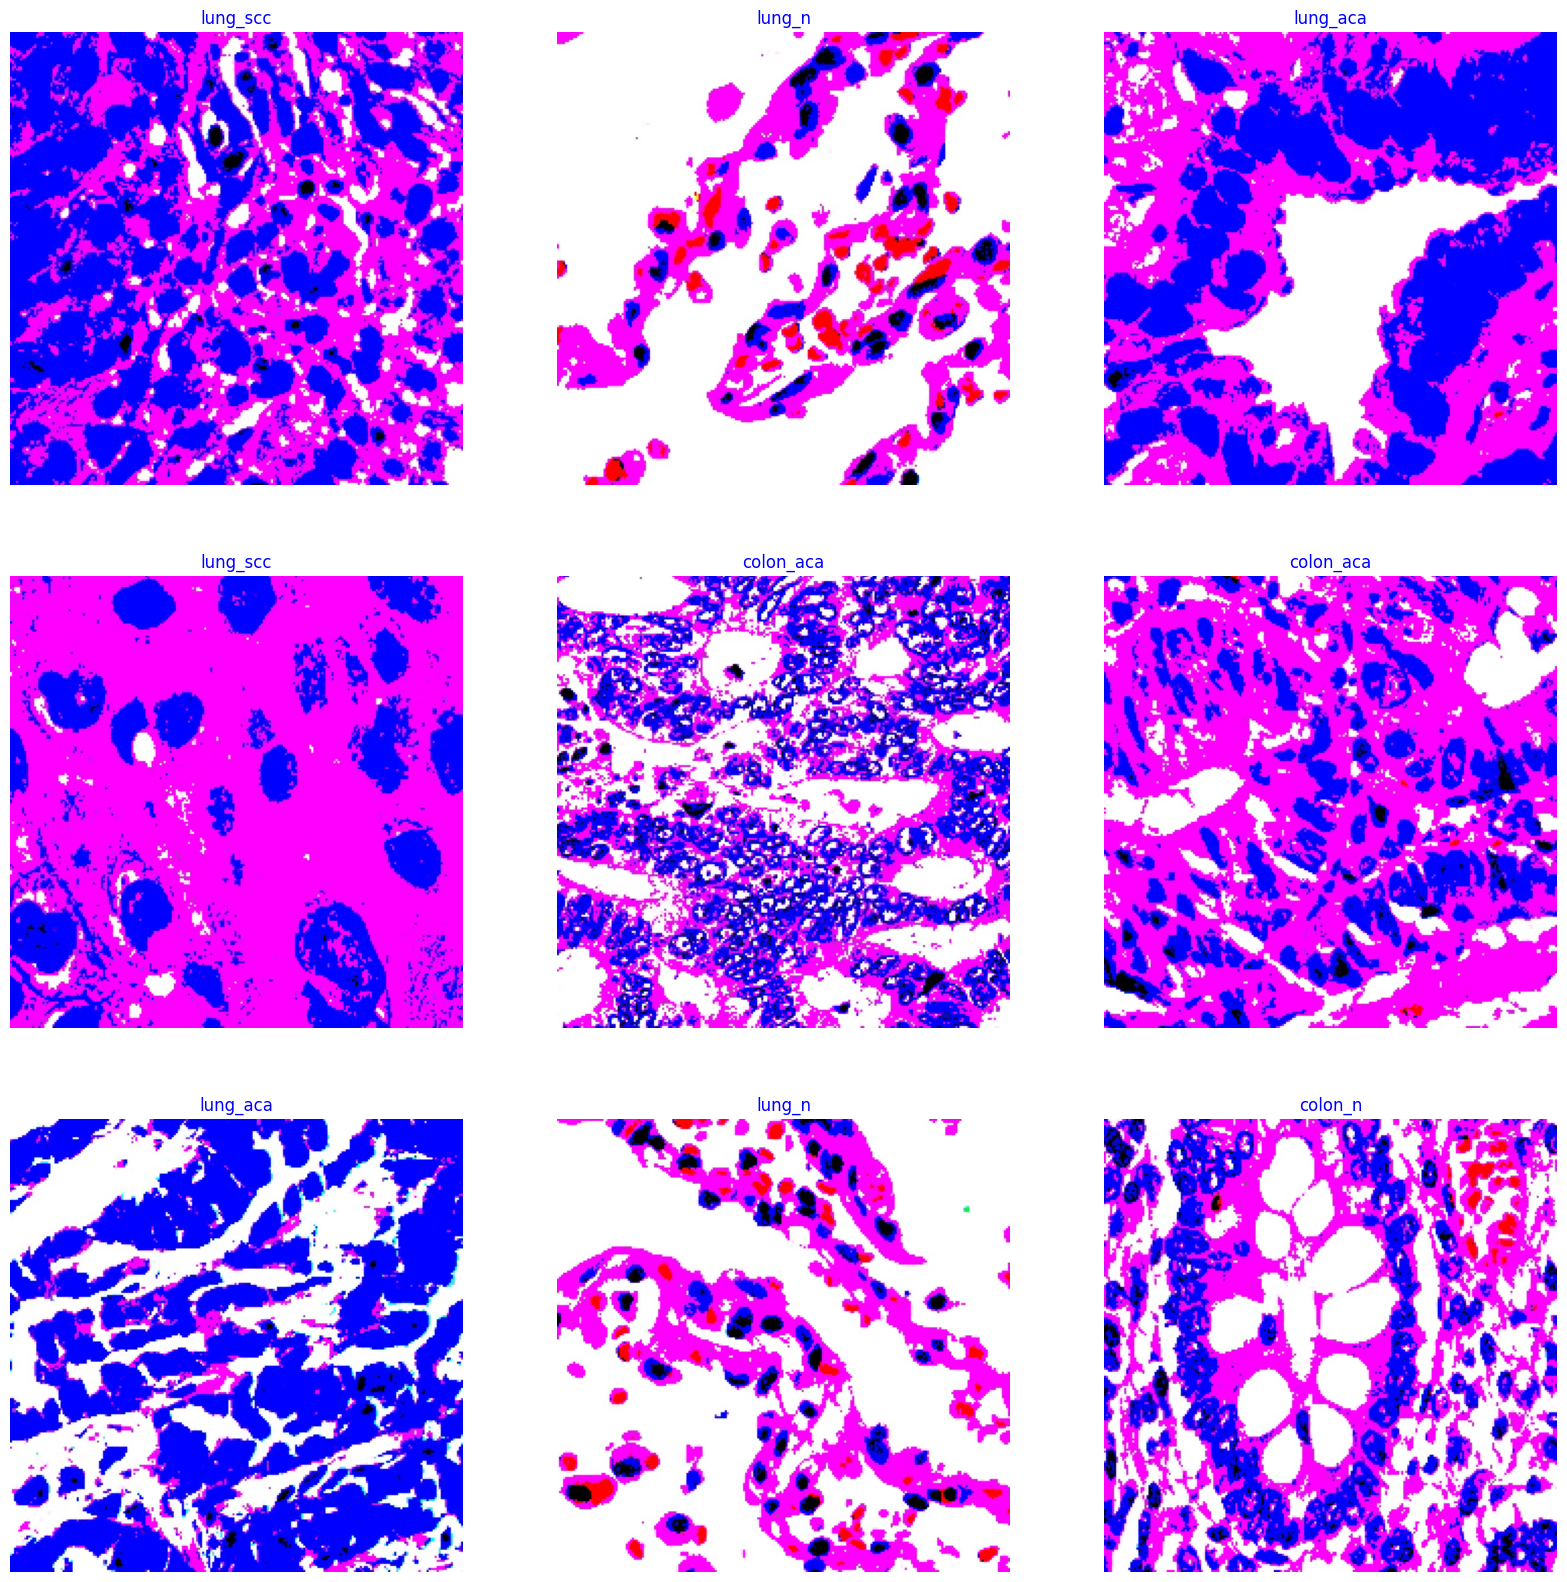

In [ ]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)

plt.figure(figsize= (20, 20))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
E85 = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
E85.trainable = False
E85.summary()

115263384/115263384 [==============================] - 3s 0us/step
Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Resc

In [ ]:
from keras.models import Model

In [ ]:
input_layer = Input(shape=(224, 224, 3))

model = (E85)(input_layer)

model = Flatten()(model)

model = Dense(4096)(model)
model = Dense(1024)(model)
model = BatchNormalization()(model)
model = ReLU()(model)

model = Dropout(rate = 0.2)(model)
model = Dense(5)(model)
output_layer = Activation('softmax')(model)
model = Model(input_layer, output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb5 (Functional  (None, 7, 7, 2048)        28513527  
 )                                                               
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 4096)              411045888 
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                              

In [ ]:
opt = Adam(learning_rate=0.005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
history = model.fit(train_gen, epochs=100, validation_data=valid_gen, callbacks=[early_stopping])

Epoch 1/100
313/313 [==============================] - 331s 984ms/step - loss: 0.3471 - accuracy: 0.8812 - val_loss: 0.3382 - val_accuracy: 0.8856
Epoch 2/100
313/313 [==============================] - 299s 955ms/step - loss: 0.1624 - accuracy: 0.9427 - val_loss: 0.1021 - val_accuracy: 0.9632
Epoch 3/100
313/313 [==============================] - 298s 952ms/step - loss: 0.0976 - accuracy: 0.9661 - val_loss: 0.1080 - val_accuracy: 0.9616
Epoch 4/100
313/313 [==============================] - 303s 968ms/step - loss: 0.0699 - accuracy: 0.9771 - val_loss: 0.0978 - val_accuracy: 0.9668
Epoch 5/100
313/313 [==============================] - 296s 945ms/step - loss: 0.0525 - accuracy: 0.9824 - val_loss: 0.0837 - val_accuracy: 0.9736
Epoch 6/100
313/313 [==============================] - 291s 928ms/step - loss: 0.0462 - accuracy: 0.9838 - val_loss: 0.0665 - val_accuracy: 0.9752
Epoch 7/100
313/313 [==============================] - 287s 917ms/step - loss: 0.0406 - accuracy: 0.9865 - val_loss: 0

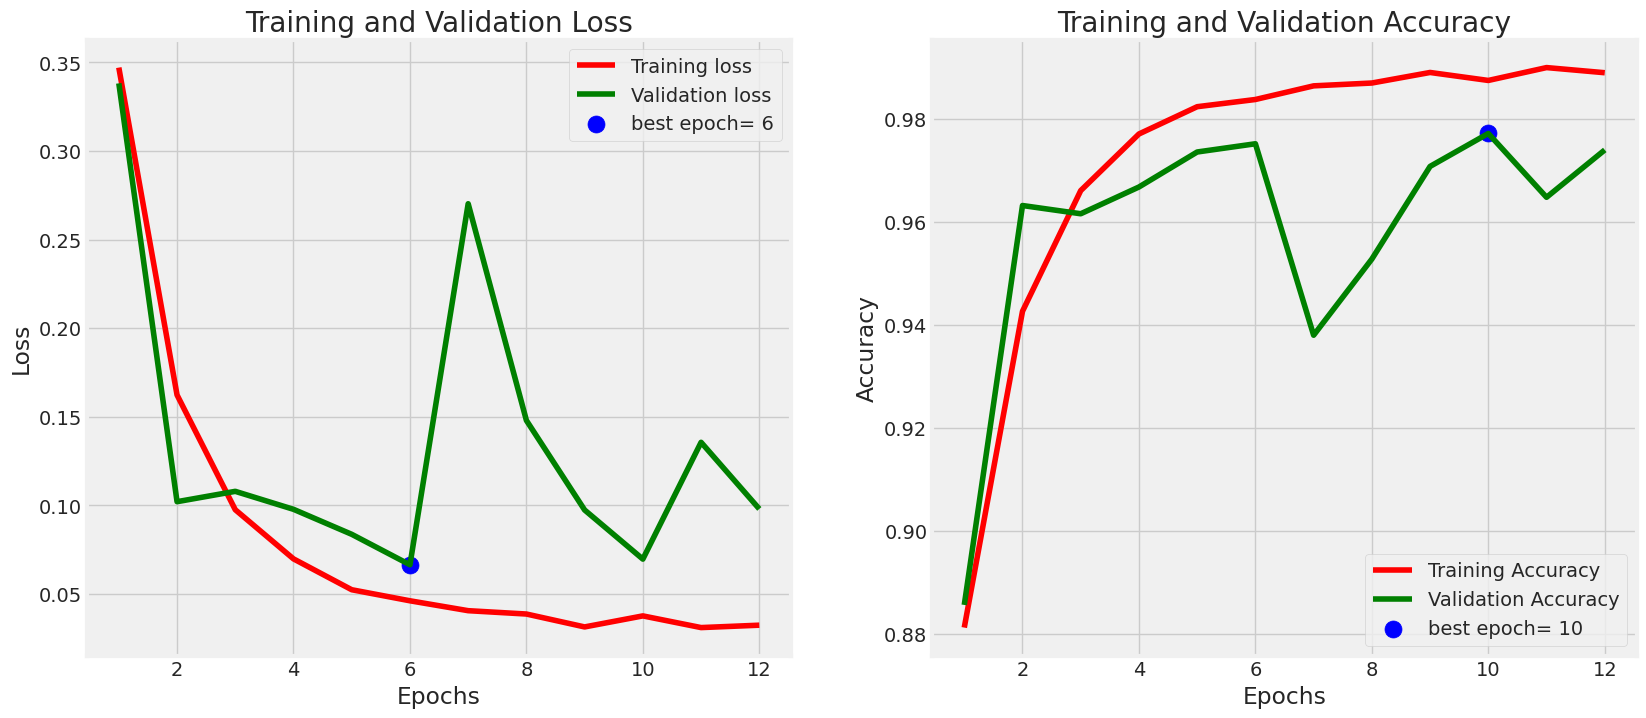

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))] #[1,2,3,4,5]

loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

40/40 [==============================] - 38s 855ms/step


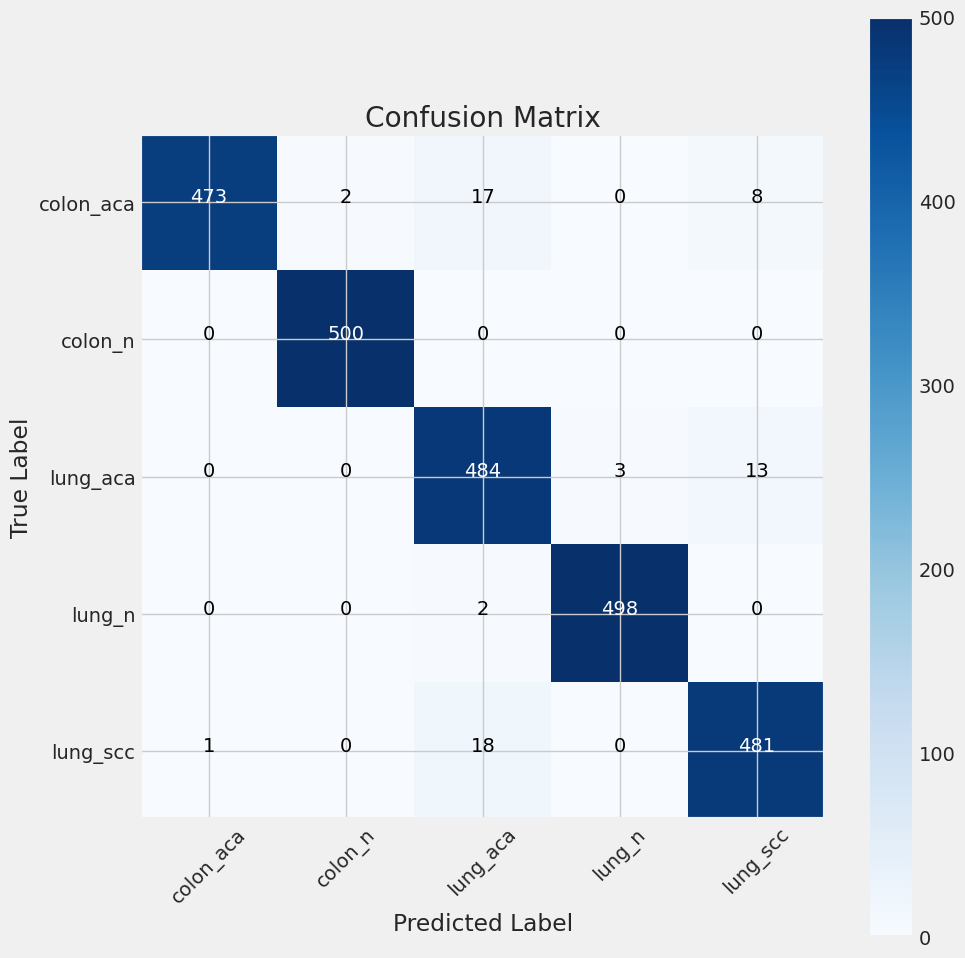

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): #(5,5)
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
def calculate_accuracy(confusion_matrix):
    # Initialize variables to store correct predictions and total predictions
    correct_predictions = 0
    total_predictions = 0

    # Iterate through the confusion matrix
    for i in range(len(confusion_matrix)):
        correct_predictions += confusion_matrix[i][i]  # Add the diagonal elements (true positives)
        total_predictions += sum(confusion_matrix[i])  # Add all elements in the row (total predictions)

    # Calculate accuracy
    accuracy = correct_predictions / total_predictions

    return accuracy

accuracy = calculate_accuracy(cm)
print("Accuracy:", accuracy)


Accuracy: 0.9744
